In [2]:
# %%
import warnings
from pathlib import Path

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display
from shapely.geometry import LineString, Point, box
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


In [3]:
# Modern color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'metro': '#C73E1D',
    'speedo': '#06A77D',
    'graph': '#7209B7',
    'hub': '#F72585',
    'background': '#F8F9FA'
}

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# %%
DATA_DIR = Path("../data")
SECTIONS_PATH = DATA_DIR / "speedo_sections.geojson"
STOPS_PATH = DATA_DIR / "speedo_routes_with_coords.csv"
CITYLINES_PATH = DATA_DIR / "lahore_sections.geojson"

CRS_LATLON = "EPSG:4326"
CRS_WEBMERC = "EPSG:3857"
CRS_UTM = "EPSG:32643"

LAHORE_BBOX = {"minx": 74.10, "maxx": 74.70, "miny": 31.30, "maxy": 31.80}

In [4]:
def load_metro_routes(citylines_path: Path = CITYLINES_PATH):
    """Load metro data with fallback to synthetic Orange Line."""
    if citylines_path.exists():
        gdf = gpd.read_file(citylines_path).to_crs(CRS_LATLON)
        source = "citylines"
    else:
        synthetic_route = gpd.GeoDataFrame(
            [{
                "metro_id": "M1",
                "line_name": "Orange Line (synthetic)",
                "geometry": LineString([
                    (74.178, 31.445), (74.232, 31.475), (74.285, 31.500),
                    (74.330, 31.530), (74.370, 31.550), (74.420, 31.570)
                ])
            }],
            crs=CRS_LATLON
        )
        gdf, source = synthetic_route, "synthetic"
    return gdf, source


In [5]:
def summarize_missing(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    summary = df.isna().sum().rename("missing").reset_index()
    summary.columns = ['column', 'missing']
    summary["pct"] = summary["missing"] / len(df) * 100
    summary["dataset"] = dataset_name
    return summary[summary['missing'] > 0].sort_values('pct', ascending=False)


In [6]:
def get_bbox_mask(df: pd.DataFrame, lon_col="longitude", lat_col="latitude", bbox=None):
    bbox = bbox or LAHORE_BBOX
    lon_ok = df[lon_col].between(bbox["minx"], bbox["maxx"])
    lat_ok = df[lat_col].between(bbox["miny"], bbox["maxy"])
    return lon_ok & lat_ok


def haversine(lon1, lat1, lon2, lat2):
    """Great-circle distance in km."""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))

In [7]:
# %% [markdown]
# ## 1. Load Datasets

# %%
sections_gdf = gpd.read_file(SECTIONS_PATH).to_crs(CRS_LATLON)
stops_raw = pd.read_csv(STOPS_PATH)
metro_gdf, metro_source = load_metro_routes()

print(f"📊 Dataset Summary")
print(f"{'='*50}")
print(f"Speedo sections: {len(sections_gdf):,} segments")
print(f"Speedo stop records: {len(stops_raw):,}")
print(f"Metro routes source: {metro_source} | features: {len(metro_gdf)}")
print(f"{'='*50}\n")

print("📋 Speedo Sections Sample:")
display(sections_gdf.head(3))

print("\n📋 Speedo Stops Sample:")
display(stops_raw.head(3))

print("\n📋 Metro Routes Sample:")
display(metro_gdf.head())

📊 Dataset Summary
Speedo sections: 34 segments
Speedo stop records: 245
Metro routes source: citylines | features: 7

📋 Speedo Sections Sample:


,id,klass,length,opening,lines,geometry
0,30000,Section,3000,2013,"[ { ""line"": ""Route 1"", ""line_url_name"": ""speed...","LINESTRING (74.33615 31.5723, 74.32699 31.5845..."
1,30001,Section,3500,2013,"[ { ""line"": ""Route 2"", ""line_url_name"": ""speed...","LINESTRING (74.29464 31.5443, 74.33323 31.5645..."
2,30002,Section,4000,2013,"[ { ""line"": ""Route 3"", ""line_url_name"": ""speed...","LINESTRING (74.33615 31.5723, 74.32699 31.5845..."



📋 Speedo Stops Sample:


,route_id,route_name,from,to,stop_index,stop_name,longitude,latitude
0,30000,Route 1,Railway Station,Bhatti Chowk,1,Railway Station,74.336,31.572
1,30000,Route 1,Railway Station,Bhatti Chowk,2,Ek Moriya,NaN,NaN
2,30000,Route 1,Railway Station,Bhatti Chowk,3,Nawaz Sharif Hospital,74.327,31.585



📋 Metro Routes Sample:


,id,klass,length,osm_id,osm_tags,osm_metadata,opening,lines,geometry
0,27066,Section,11900,"818,457,073.000","{""bridge"":""yes"",""electrified"":""rail"",""gauge"":""...","{""version"":9}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (74.3038 31.55267, 74.3034 31.55248..."
1,27067,Section,707,"818,457,074.000","{""bridge"":""yes"",""electrified"":""rail"",""gauge"":""...","{""version"":6}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (74.30658 31.55841, 74.30654 31.558..."
2,27068,Section,259,"818,457,075.000","{""covered"":""yes"",""cutting"":""yes"",""electrified""...","{""version"":6}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (74.30763 31.56056, 74.30735 31.560..."
3,27069,Section,1311,"818,457,076.000","{""electrified"":""rail"",""gauge"":""1435"",""layer"":""...","{""version"":6}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (74.31878 31.56632, 74.31825 31.566..."
4,27070,Section,200,"818,457,077.000","{""cutting"":""yes"",""electrified"":""rail"",""gauge"":...","{""version"":6}",2020,"[ { ""line"": ""Orange Line"", ""line_url_name"": ""4...","LINESTRING (74.32087 31.56652, 74.31878 31.56632)"


In [9]:
#%% [markdown]
# ## 2. Data Quality Assessment

# %%
stops_profile = stops_raw.copy()
stops_profile["latitude"] = pd.to_numeric(stops_profile["latitude"], errors="coerce")
stops_profile["longitude"] = pd.to_numeric(stops_profile["longitude"], errors="coerce")

missing_summary = pd.concat([
    summarize_missing(stops_profile, "speedo_stops"),
    summarize_missing(sections_gdf.drop(columns="geometry"), "speedo_sections")
], ignore_index=True)

print("🔍 Data Quality Report")
print(f"{'='*70}")
if len(missing_summary) > 0:
    display(missing_summary)
else:
    print("✅ No missing values detected!")

invalid_coords = stops_profile[~get_bbox_mask(stops_profile)]
print(f"\n⚠️  Records outside Lahore bbox: {len(invalid_coords)} ({len(invalid_coords)/len(stops_profile)*100:.1f}%)")
if len(invalid_coords) > 0:
    display(invalid_coords.head())

🔍 Data Quality Report


,column,missing,pct,dataset
0,longitude,59,24.082,speedo_stops
1,latitude,59,24.082,speedo_stops



⚠️  Records outside Lahore bbox: 63 (25.7%)


,route_id,route_name,from,to,stop_index,stop_name,longitude,latitude
1,30000,Route 1,Railway Station,Bhatti Chowk,2,Ek Moriya,NaN,NaN
6,30000,Route 1,Railway Station,Bhatti Chowk,7,Texali Chowk,NaN,NaN
12,30001,Route 2,Samanabad Mor,Bhatti Chowk,5,Double Sarkan,NaN,NaN
17,30002,Route 3,Railway Station,Shahdara Lari Adda,2,Ek Moriya,NaN,NaN
25,30002,Route 3,Railway Station,Shahdara Lari Adda,10,Shahdara Metro Station,NaN,NaN


In [10]:
# %% [markdown]
# ## 3. Data Cleaning & Enhanced Feature Engineering

# %%
def clean_speedo_stops(df: pd.DataFrame) -> tuple[gpd.GeoDataFrame, dict]:
    """Clean stops with detailed tracking of all operations."""
    stats = {'original_rows': len(df)}
    cleaned = df.copy()
    
    # Type conversions
    cleaned["route_id"] = cleaned["route_id"].astype(str)
    cleaned["stop_index"] = pd.to_numeric(cleaned["stop_index"], errors="coerce")
    cleaned["stop_name"] = cleaned["stop_name"].str.strip()
    
    for col in ("latitude", "longitude"):
        cleaned[col] = pd.to_numeric(cleaned[col], errors="coerce")
    
    # Remove invalid stop indices
    cleaned = cleaned.dropna(subset=["stop_index"])
    cleaned["stop_index"] = cleaned["stop_index"].astype(int)
    cleaned.sort_values(["route_id", "stop_index"], inplace=True)
    stats['after_index_clean'] = len(cleaned)
    
    # Coordinate imputation tracking
    cleaned["coord_fix"] = "original"
    needs_interp = cleaned[["latitude", "longitude"]].isna().any(axis=1)
    cleaned.loc[needs_interp, "coord_fix"] = "route_interp"
    
    # Route-level interpolation
    cleaned[["latitude", "longitude"]] = cleaned.groupby("route_id")[["latitude", "longitude"]].transform(
        lambda g: g.interpolate(limit_direction="both")
    )
    
    # Stop-level mean imputation for remaining NaNs
    still_missing = cleaned[["latitude", "longitude"]].isna().any(axis=1)
    cleaned.loc[still_missing, "coord_fix"] = "stop_mean"
    coord_means = cleaned.groupby("stop_name")[["latitude", "longitude"]].transform("mean")
    cleaned[["latitude", "longitude"]] = cleaned[["latitude", "longitude"]].fillna(coord_means)
    
    # Final cleanup
    before_final = len(cleaned)
    cleaned = cleaned.dropna(subset=["latitude", "longitude"])
    bbox_mask = get_bbox_mask(cleaned)
    cleaned = cleaned[bbox_mask].copy()
    stats['dropped_invalid'] = before_final - len(cleaned)
    stats['final_rows'] = len(cleaned)
    
    # Enhanced feature engineering
    slug = (cleaned["stop_name"].str.lower()
            .str.replace("[^a-z0-9]+", "_", regex=True)
            .str.strip("_").replace("", "unnamed_stop"))
    cleaned["stop_slug"] = slug
    cleaned["stop_uid"] = (cleaned["stop_slug"] + "_" + 
                           cleaned["latitude"].round(4).astype(str) + "_" + 
                           cleaned["longitude"].round(4).astype(str))
    
    # Create geometry
    cleaned["geometry"] = gpd.points_from_xy(cleaned["longitude"], cleaned["latitude"], crs=CRS_LATLON)
    
    # One-hot encode coordinate fix method
    fix_dummies = pd.get_dummies(cleaned["coord_fix"], prefix="fix")
    cleaned = pd.concat([cleaned, fix_dummies], axis=1)
    
    cleaned_gdf = gpd.GeoDataFrame(cleaned, geometry="geometry", crs=CRS_LATLON)
    return cleaned_gdf, stats


speedo_stops, cleaning_stats = clean_speedo_stops(stops_raw)

print("🧹 Cleaning Statistics")
print(f"{'='*50}")
for key, value in cleaning_stats.items():
    print(f"{key.replace('_', ' ').title()}: {value:,}")
print(f"{'='*50}\n")

print("📊 Coordinate Fix Distribution:")
display(speedo_stops['coord_fix'].value_counts())

print("\n✅ Cleaned Data Sample:")
display(speedo_stops.head())

🧹 Cleaning Statistics
Original Rows: 245
After Index Clean: 245
Dropped Invalid: 4
Final Rows: 241

📊 Coordinate Fix Distribution:


coord_fix
original        182
route_interp     59
Name: count, dtype: int64


✅ Cleaned Data Sample:


,route_id,route_name,from,to,stop_index,stop_name,longitude,latitude,coord_fix,stop_slug,stop_uid,geometry,fix_original,fix_route_interp
0,30000,Route 1,Railway Station,Bhatti Chowk,1,Railway Station,74.336,31.572,original,railway_station,railway_station_31.5723_74.3362,POINT (74.33615 31.5723),True,False
1,30000,Route 1,Railway Station,Bhatti Chowk,2,Ek Moriya,74.332,31.578,route_interp,ek_moriya,ek_moriya_31.5784_74.3316,POINT (74.33157 31.57844),False,True
2,30000,Route 1,Railway Station,Bhatti Chowk,3,Nawaz Sharif Hospital,74.327,31.585,original,nawaz_sharif_hospital,nawaz_sharif_hospital_31.5846_74.327,POINT (74.32699 31.58459),True,False
3,30000,Route 1,Railway Station,Bhatti Chowk,4,Kashmiri Gate,74.321,31.587,original,kashmiri_gate,kashmiri_gate_31.5868_74.321,POINT (74.32104 31.58684),True,False
4,30000,Route 1,Railway Station,Bhatti Chowk,5,Lari Adda,74.315,31.596,original,lari_adda,lari_adda_31.596_74.3149,POINT (74.31488 31.596),True,False


In [11]:
# %% [markdown]
# ## 4. Enhanced Aggregations & Statistics

# %%
# Route-level aggregations
route_stop_counts = (
    speedo_stops.groupby(["route_id", "route_name", "from", "to"])
    .agg(
        total_stop_records=("stop_name", "count"),
        unique_stops=("stop_uid", "nunique"),
        imputed_coords=("coord_fix", lambda x: (x != "original").sum()),
        avg_lat=("latitude", "mean"),
        avg_lon=("longitude", "mean")
    )
    .reset_index()
    .sort_values("unique_stops", ascending=False)
)

# Stop frequency analysis
stop_frequency = (
    speedo_stops.groupby("stop_name")
    .agg(
        routes_served=("route_id", "nunique"),
        total_occurrences=("stop_name", "count"),
        avg_lat=("latitude", "mean"),
        avg_lon=("longitude", "mean")
    )
    .reset_index()
    .sort_values("routes_served", ascending=False)
)

# Section-level metrics
sections_gdf = sections_gdf.copy()
sections_gdf["route_id"] = sections_gdf["id"].astype(str)
sections_gdf["section_km"] = sections_gdf["length"].astype(float) / 1000

route_lengths = (
    sections_gdf.groupby("route_id")
    .agg(
        route_km=("section_km", "sum"),
        avg_section_km=("section_km", "mean"),
        sections=("route_id", "count"),
        min_section_km=("section_km", "min"),
        max_section_km=("section_km", "max")
    )
    .reset_index()
)

# Comprehensive route statistics
route_stats = (
    route_stop_counts.merge(route_lengths, on="route_id", how="left")
    .assign(
        stops_per_km=lambda df: df["unique_stops"] / df["route_km"],
        avg_stop_spacing_km=lambda df: df["route_km"] / df["unique_stops"]
    )
    .sort_values("stops_per_km", ascending=False)
)

print("📈 Top 10 Routes by Stop Count:")
display(route_stop_counts.head(10))

print("\n🚏 Top 10 High-Traffic Stops:")
display(stop_frequency.head(10))

print("\n📏 Route Density Statistics:")
display(route_stats.describe().round(2))

📈 Top 10 Routes by Stop Count:


,route_id,route_name,from,to,total_stop_records,unique_stops,imputed_coords,avg_lat,avg_lon
10,30010,Route 11,Babu Sabu,Main Market Gulberg,16,16,6,31.518,74.310
11,30011,Route 12,R.A Bazar,Civil Secretariat,13,13,2,31.540,74.343
6,30006,Route 7,Bagrian,Chungi Amar Sidhu,12,12,4,31.454,74.333
12,30012,Route 13,Bagrian,Kalma Chowk,11,11,4,31.466,74.312
9,30009,Route 10,Multan Chungi,Qartaba Chowk,11,11,2,31.512,74.294
2,30002,Route 3,Railway Station,Shahdara Lari Adda,11,11,3,31.591,74.312
13,30013,Route 14,R.A Bazar,Chungi Amar Sidhu,10,10,3,31.483,74.343
5,30005,Route 6,Babu Sabu,Raj Garh Chowk,10,10,5,31.550,74.292
4,30004,Route 5,Shad Bagh Underpass,Bhatti Chowk,9,9,3,31.573,74.327
8,30008,Route 9,Railway Station,Sham Nagar,9,9,2,31.558,74.322



🚏 Top 10 High-Traffic Stops:


,stop_name,routes_served,total_occurrences,avg_lat,avg_lon
130,Railway Station,6,6,31.572,74.336
58,Ghazi Chowk,5,5,31.437,74.291
129,R.A Bazar,5,5,31.500,74.383
38,Daroghawala,4,4,31.587,74.404
46,Ek Moriya,4,4,31.539,74.316
151,Shimla Pahari,4,4,31.562,74.337
34,Cooper Store,3,3,31.545,74.339
41,Depot Chowk,3,3,31.494,74.406
22,Canal,3,3,31.465,74.253
11,Babu Sabu,3,3,31.544,74.259



📏 Route Density Statistics:


,total_stop_records,unique_stops,imputed_coords,avg_lat,avg_lon,route_km,avg_section_km,sections,min_section_km,max_section_km,stops_per_km,avg_stop_spacing_km
count,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
mean,7.090,7.090,1.740,31.530,74.330,2.750,2.750,1.000,2.750,2.750,2.540,0.410
std,3.210,3.210,1.520,0.040,0.030,1.020,1.020,0.000,1.020,1.020,0.450,0.070
min,3.000,3.000,0.000,31.430,74.270,1.500,1.500,1.000,1.500,1.500,2.000,0.290
25%,5.000,5.000,1.000,31.510,74.310,2.000,2.000,1.000,2.000,2.000,2.000,0.350
50%,6.000,6.000,1.000,31.540,74.320,2.500,2.500,1.000,2.500,2.500,2.500,0.400
75%,9.000,9.000,3.000,31.570,74.340,3.500,3.500,1.000,3.500,3.500,2.860,0.500
max,16.000,16.000,6.000,31.600,74.440,5.500,5.500,1.000,5.500,5.500,3.500,0.500


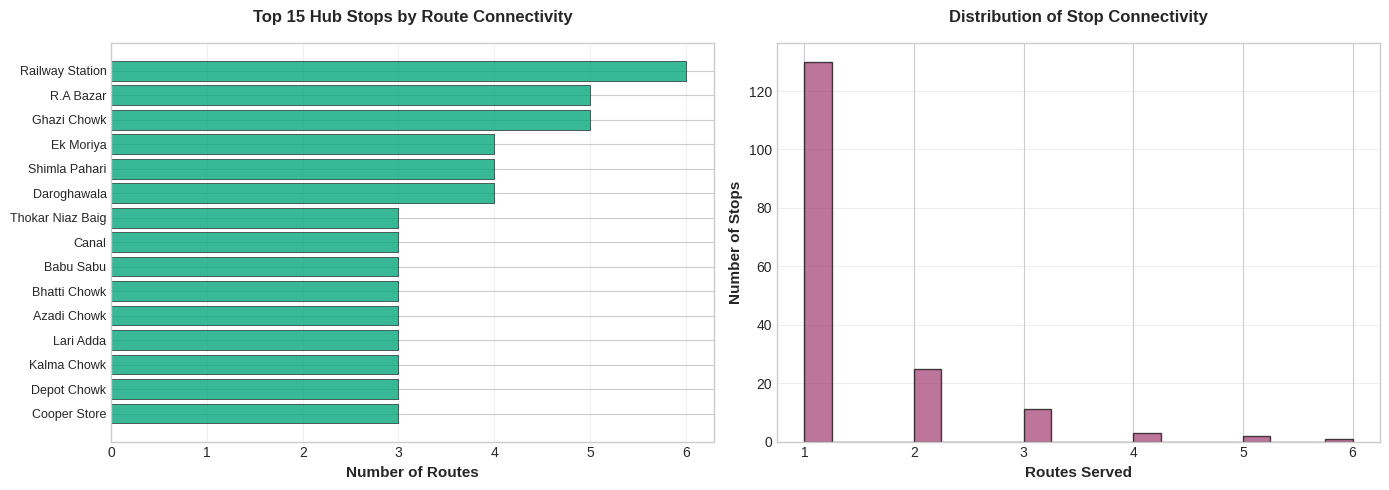

In [12]:
# %% [markdown]
# ## 5. Enhanced Visualizations

# %%
# Figure 1: Stop Frequency Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal bar chart
top_freq = stop_frequency.head(15).sort_values("routes_served")
axes[0].barh(range(len(top_freq)), top_freq["routes_served"], 
             color=COLORS['speedo'], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(range(len(top_freq)))
axes[0].set_yticklabels(top_freq["stop_name"], fontsize=9)
axes[0].set_xlabel("Number of Routes", fontsize=11, fontweight='bold')
axes[0].set_title("Top 15 Hub Stops by Route Connectivity", fontsize=12, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3)

# Distribution histogram
axes[1].hist(stop_frequency["routes_served"], bins=20, 
             color=COLORS['secondary'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel("Routes Served", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Number of Stops", fontsize=11, fontweight='bold')
axes[1].set_title("Distribution of Stop Connectivity", fontsize=12, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('stop_frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


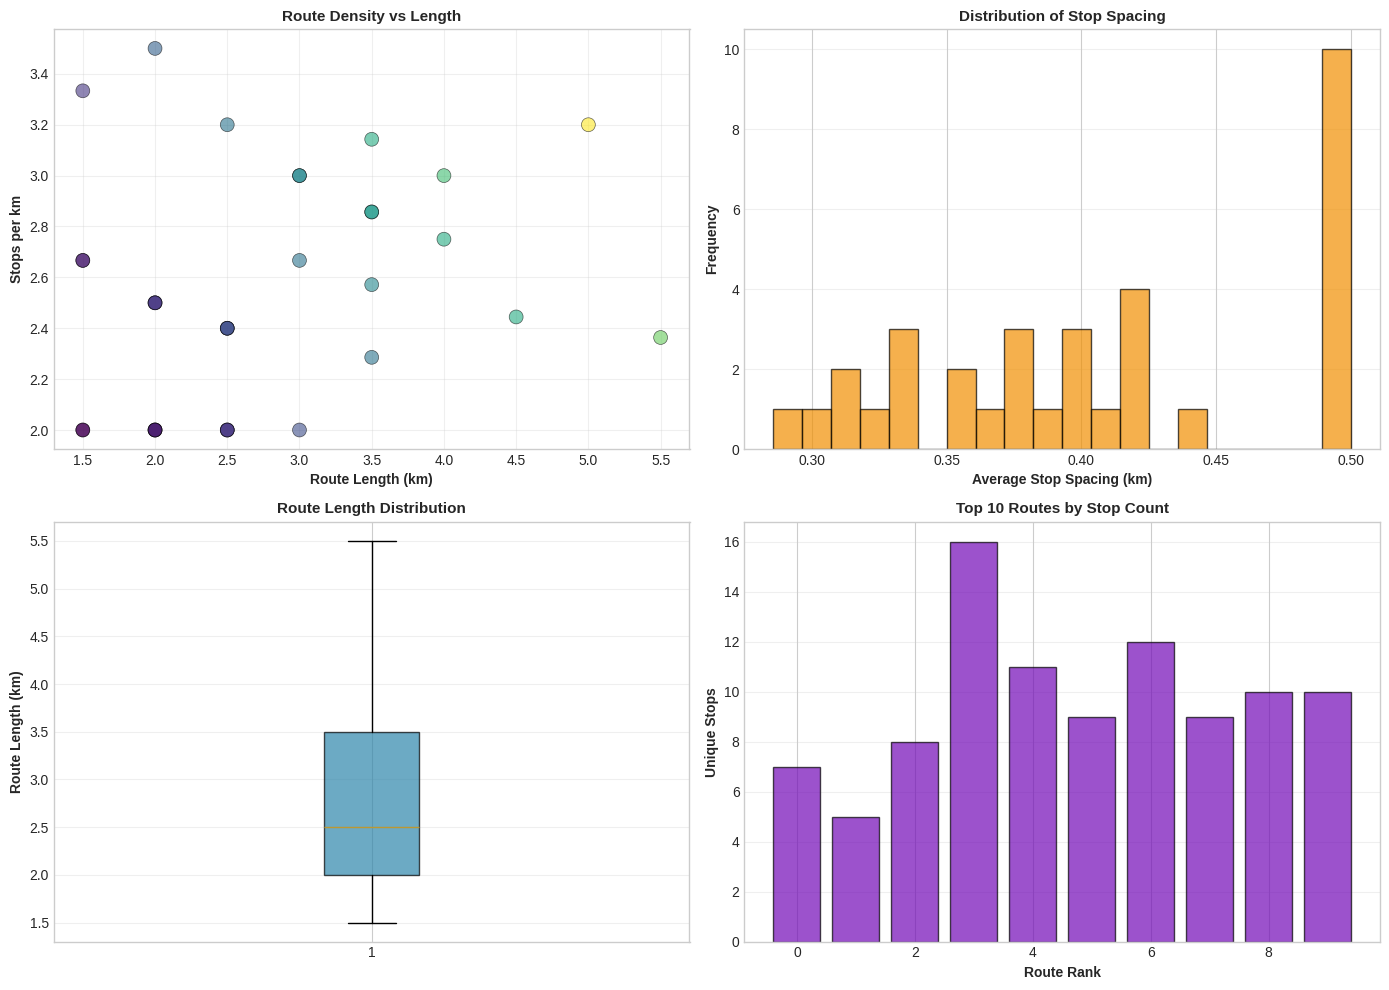

In [13]:
# %%
# Figure 2: Route Density Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stops per km
axes[0,0].scatter(route_stats["route_km"], route_stats["stops_per_km"], 
                  s=100, alpha=0.6, c=route_stats["unique_stops"], 
                  cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0,0].set_xlabel("Route Length (km)", fontsize=10, fontweight='bold')
axes[0,0].set_ylabel("Stops per km", fontsize=10, fontweight='bold')
axes[0,0].set_title("Route Density vs Length", fontsize=11, fontweight='bold')
axes[0,0].grid(alpha=0.3)

# Stop spacing
axes[0,1].hist(route_stats["avg_stop_spacing_km"].dropna(), bins=20,
               color=COLORS['accent'], alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel("Average Stop Spacing (km)", fontsize=10, fontweight='bold')
axes[0,1].set_ylabel("Frequency", fontsize=10, fontweight='bold')
axes[0,1].set_title("Distribution of Stop Spacing", fontsize=11, fontweight='bold')
axes[0,1].grid(axis='y', alpha=0.3)

# Route length distribution
axes[1,0].boxplot([route_stats["route_km"].dropna()], vert=True, patch_artist=True,
                   boxprops=dict(facecolor=COLORS['primary'], alpha=0.7))
axes[1,0].set_ylabel("Route Length (km)", fontsize=10, fontweight='bold')
axes[1,0].set_title("Route Length Distribution", fontsize=11, fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)

# Unique stops distribution
axes[1,1].bar(range(len(route_stats.head(10))), 
              route_stats.head(10)["unique_stops"],
              color=COLORS['graph'], alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel("Route Rank", fontsize=10, fontweight='bold')
axes[1,1].set_ylabel("Unique Stops", fontsize=10, fontweight='bold')
axes[1,1].set_title("Top 10 Routes by Stop Count", fontsize=11, fontweight='bold')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('route_density_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# %% [markdown]
# ## 6. Enhanced Graph Construction

# %%
def build_speedo_graph(stop_gdf: gpd.GeoDataFrame) -> nx.Graph:
    """Build graph with enhanced node/edge attributes."""
    G = nx.Graph()
    
    # Add nodes with rich attributes
    for _, row in stop_gdf.iterrows():
        node_id = row["stop_uid"]
        pos = (row["longitude"], row["latitude"])
        
        if G.has_node(node_id):
            G.nodes[node_id]["routes"].add(row["route_id"])
            G.nodes[node_id]["route_names"].add(row["route_name"])
        else:
            G.add_node(
                node_id,
                stop_name=row["stop_name"],
                routes={row["route_id"]},
                route_names={row["route_name"]},
                pos=pos,
                coord_fix=row["coord_fix"]
            )
    
    # Add edges with distance weighting
    for route_id, route_df in stop_gdf.groupby("route_id"):
        ordered = route_df.sort_values("stop_index")
        for idx in range(len(ordered) - 1):
            u = ordered.iloc[idx]["stop_uid"]
            v = ordered.iloc[idx + 1]["stop_uid"]
            dist_km = haversine(
                ordered.iloc[idx]["longitude"], ordered.iloc[idx]["latitude"],
                ordered.iloc[idx + 1]["longitude"], ordered.iloc[idx + 1]["latitude"]
            )
            
            if G.has_edge(u, v):
                G.edges[u, v]["route_id_set"].add(route_id)
                G.edges[u, v]["weight_km"] = np.mean([G.edges[u, v]["weight_km"], dist_km])
                G.edges[u, v]["overlap_count"] += 1
            else:
                G.add_edge(u, v, route_id_set={route_id}, weight_km=dist_km, overlap_count=1)
    
    # Convert sets to sorted lists
    for node in G.nodes():
        G.nodes[node]["routes"] = sorted(G.nodes[node]["routes"])
        G.nodes[node]["route_names"] = sorted(G.nodes[node]["route_names"])
        G.nodes[node]["degree"] = G.degree(node)
    
    for u, v in G.edges():
        G.edges[u, v]["route_id_set"] = sorted(G.edges[u, v]["route_id_set"])
    
    return G


speedo_graph = build_speedo_graph(speedo_stops)

print("🕸️  Network Statistics")
print(f"{'='*50}")
print(f"Nodes (stops): {speedo_graph.number_of_nodes():,}")
print(f"Edges (connections): {speedo_graph.number_of_edges():,}")
print(f"Density: {nx.density(speedo_graph):.4f}")
print(f"Average degree: {sum(dict(speedo_graph.degree()).values()) / speedo_graph.number_of_nodes():.2f}")
print(f"{'='*50}")

🕸️  Network Statistics
Nodes (stops): 185
Edges (connections): 195
Density: 0.0115
Average degree: 2.11


In [15]:
# %% [markdown]
# ## 7. Advanced SNA Metrics

# %%
print("🔬 Computing Advanced SNA Metrics...")

# Core centrality measures
degree_centrality = nx.degree_centrality(speedo_graph)
betweenness = nx.betweenness_centrality(speedo_graph, weight="weight_km")
closeness = nx.closeness_centrality(speedo_graph, distance="weight_km")

# Additional advanced metrics
eigenvector = nx.eigenvector_centrality(speedo_graph, max_iter=1000, weight="weight_km")
clustering = nx.clustering(speedo_graph)

# Compile comprehensive metrics
metrics_df = pd.DataFrame({
    "degree_centrality": degree_centrality,
    "betweenness": betweenness,
    "closeness": closeness,
    "eigenvector": eigenvector,
    "clustering": clustering
}).assign(
    stop_name=lambda df: df.index.map(lambda n: speedo_graph.nodes[n]["stop_name"]),
    routes=lambda df: df.index.map(lambda n: ", ".join(speedo_graph.nodes[n]["routes"])),
    route_count=lambda df: df.index.map(lambda n: len(speedo_graph.nodes[n]["routes"]))
).sort_values("betweenness", ascending=False)

# One-hot encode high centrality nodes
metrics_df["high_betweenness"] = (metrics_df["betweenness"] > metrics_df["betweenness"].quantile(0.9)).astype(int)
metrics_df["high_degree"] = (metrics_df["degree_centrality"] > metrics_df["degree_centrality"].quantile(0.9)).astype(int)
metrics_df["high_eigenvector"] = (metrics_df["eigenvector"] > metrics_df["eigenvector"].quantile(0.9)).astype(int)

print("\n⭐ Top 15 Critical Hubs (by Betweenness):")
display(metrics_df.head(15))

print("\n📊 Centrality Statistics:")
display(metrics_df[['degree_centrality', 'betweenness', 'closeness', 'eigenvector', 'clustering']].describe())

# Connected components analysis
components = sorted(nx.connected_components(speedo_graph), key=len, reverse=True)
print(f"\n🔗 Network has {len(components)} connected component(s)")
print(f"Largest component size: {len(components[0])} nodes ({len(components[0])/speedo_graph.number_of_nodes()*100:.1f}%)")


🔬 Computing Advanced SNA Metrics...

⭐ Top 15 Critical Hubs (by Betweenness):


,degree_centrality,betweenness,closeness,eigenvector,clustering,stop_name,routes,route_count,high_betweenness,high_degree,high_eigenvector
shimla_pahari_31.5621_74.3365,0.027,0.299,0.041,0.000,0,Shimla Pahari,"30008, 30016, 30017, 30031",4,1,1,0
railway_station_31.5723_74.3362,0.022,0.285,0.040,0.000,0,Railway Station,"30000, 30002, 30008, 30015, 30016, 30024",6,1,1,0
r_a_bazar_31.5001_74.3834,0.027,0.229,0.036,0.000,0,R.A Bazar,"30003, 30011, 30013, 30024, 30025",5,1,1,0
haji_camp_31.5711_74.3344,0.011,0.222,0.040,0.000,0,Haji Camp,"30008, 30016",2,1,0,0
qainchi_31.4644_74.3483,0.016,0.214,0.035,0.000,0,Qainchi,"30003, 30006",2,1,0,1
nadeem_chowk_31.4967_74.379,0.011,0.196,0.036,0.000,0,Nadeem Chowk,30003,1,1,0,0
defence_morr_31.4934_74.3746,0.011,0.195,0.036,0.000,0,Defence Morr,30003,1,1,0,0
shareef_market_31.49_74.3702,0.011,0.194,0.036,0.000,0,Shareef Market,30003,1,1,0,0
walton_31.4867_74.3658,0.011,0.193,0.036,0.000,0,Walton,30003,1,1,0,0
kalma_chowk_31.5042_74.3313,0.022,0.184,0.035,0.000,0,Kalma Chowk,"30007, 30010, 30012",3,1,1,0



📊 Centrality Statistics:


,degree_centrality,betweenness,closeness,eigenvector,clustering
count,185.000,185.000,185.000,185.000,185.000
mean,0.011,0.054,0.028,0.012,0.000
std,0.004,0.064,0.010,0.073,0.000
min,0.005,0.000,0.001,0.000,0.000
25%,0.011,0.006,0.023,0.000,0.000
50%,0.011,0.024,0.032,0.000,0.000
75%,0.011,0.094,0.035,0.000,0.000
max,0.033,0.299,0.041,0.601,0.000



🔗 Network has 4 connected component(s)
Largest component size: 168 nodes (90.8%)


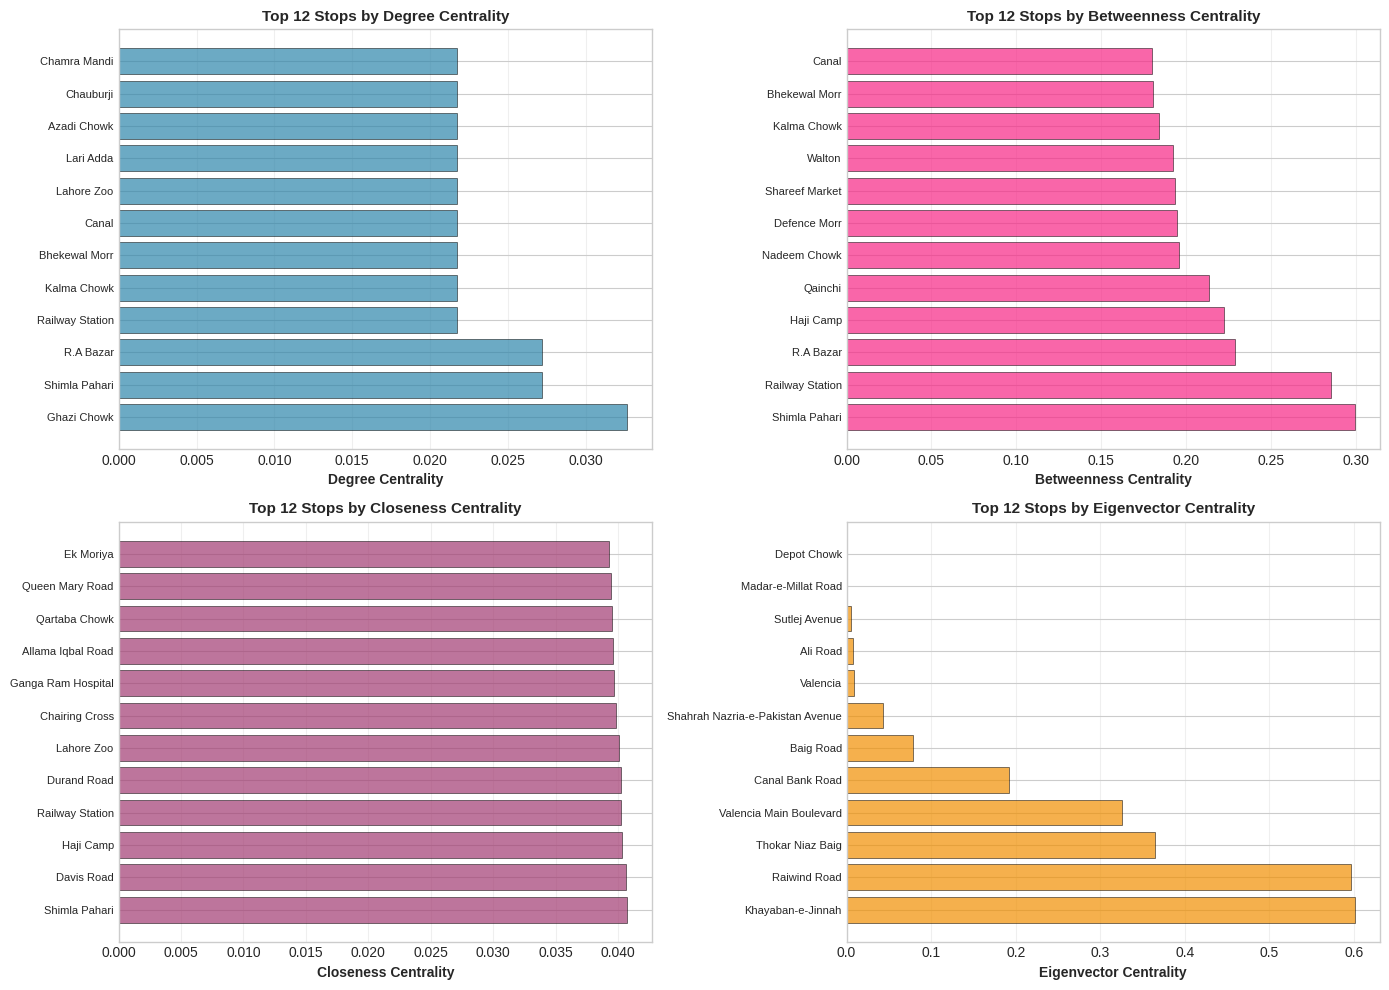

In [16]:
# %% [markdown]
# ## 8. Enhanced Graph Visualizations

# %%
# Figure 3: Centrality Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

centrality_measures = [
    ('degree_centrality', 'Degree Centrality', COLORS['primary']),
    ('betweenness', 'Betweenness Centrality', COLORS['hub']),
    ('closeness', 'Closeness Centrality', COLORS['secondary']),
    ('eigenvector', 'Eigenvector Centrality', COLORS['accent'])
]

for idx, (measure, title, color) in enumerate(centrality_measures):
    ax = axes[idx // 2, idx % 2]
    top_n = metrics_df.nlargest(12, measure)
    
    ax.barh(range(len(top_n)), top_n[measure], color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(top_n)))
    ax.set_yticklabels(top_n["stop_name"], fontsize=8)
    ax.set_xlabel(title, fontsize=10, fontweight='bold')
    ax.set_title(f"Top 12 Stops by {title}", fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


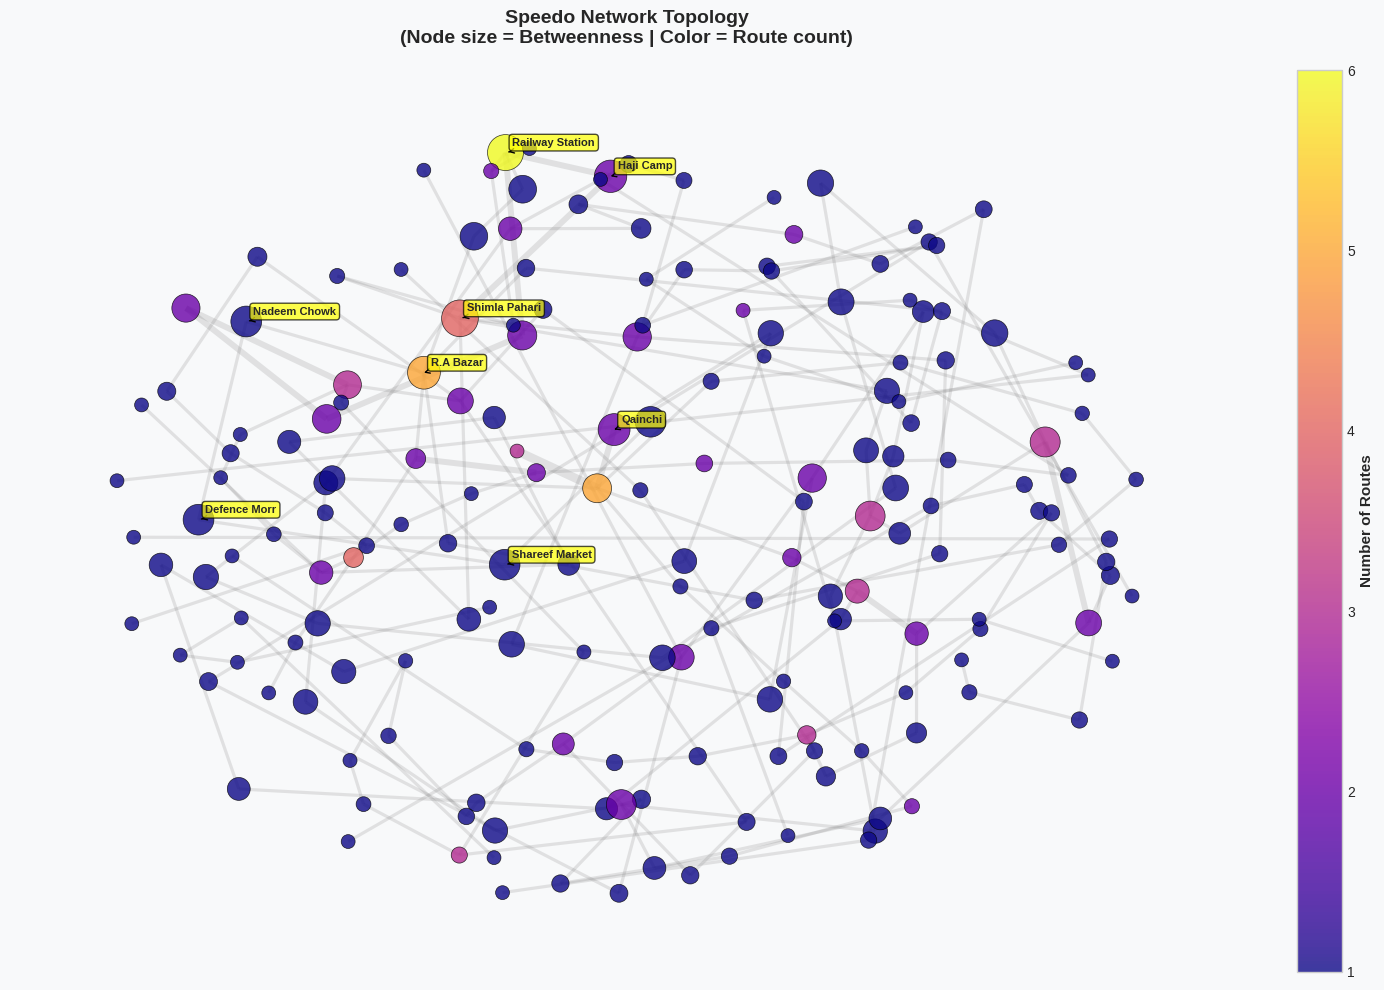

In [18]:
# %%
# Figure 4: Network Topology (Spring Layout with Size by Betweenness)
pos_spring = nx.spring_layout(speedo_graph, weight="weight_km", seed=42, k=0.4, iterations=50)

node_sizes = [100 + 2000 * betweenness[node] for node in speedo_graph.nodes()]
node_colors = [metrics_df.loc[node, "route_count"] for node in speedo_graph.nodes()]
edge_widths = [0.3 + 2 * speedo_graph.edges[u, v].get("overlap_count", 1) for u, v in speedo_graph.edges()]

fig, ax = plt.subplots(figsize=(14, 10), facecolor=COLORS['background'])
ax.set_facecolor(COLORS['background'])

# Draw edges
nx.draw_networkx_edges(speedo_graph, pos_spring, alpha=0.2, edge_color='gray', 
                       width=edge_widths, ax=ax)

# Draw nodes
nodes = nx.draw_networkx_nodes(speedo_graph, pos_spring, node_size=node_sizes,
                               node_color=node_colors, cmap='plasma', alpha=0.8,
                               edgecolors='black', linewidths=0.5, ax=ax)

# Add colorbar
cbar = plt.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Number of Routes', fontsize=11, fontweight='bold')

# Annotate top hubs
top_hubs = metrics_df.nlargest(8, "betweenness").index
for node in top_hubs:
    x, y = pos_spring[node]
    ax.annotate(speedo_graph.nodes[node]["stop_name"], 
                xy=(x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1))

ax.set_title("Speedo Network Topology\n(Node size = Betweenness | Color = Route count)", 
             fontsize=14, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('network_topology.png', dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
plt.show()

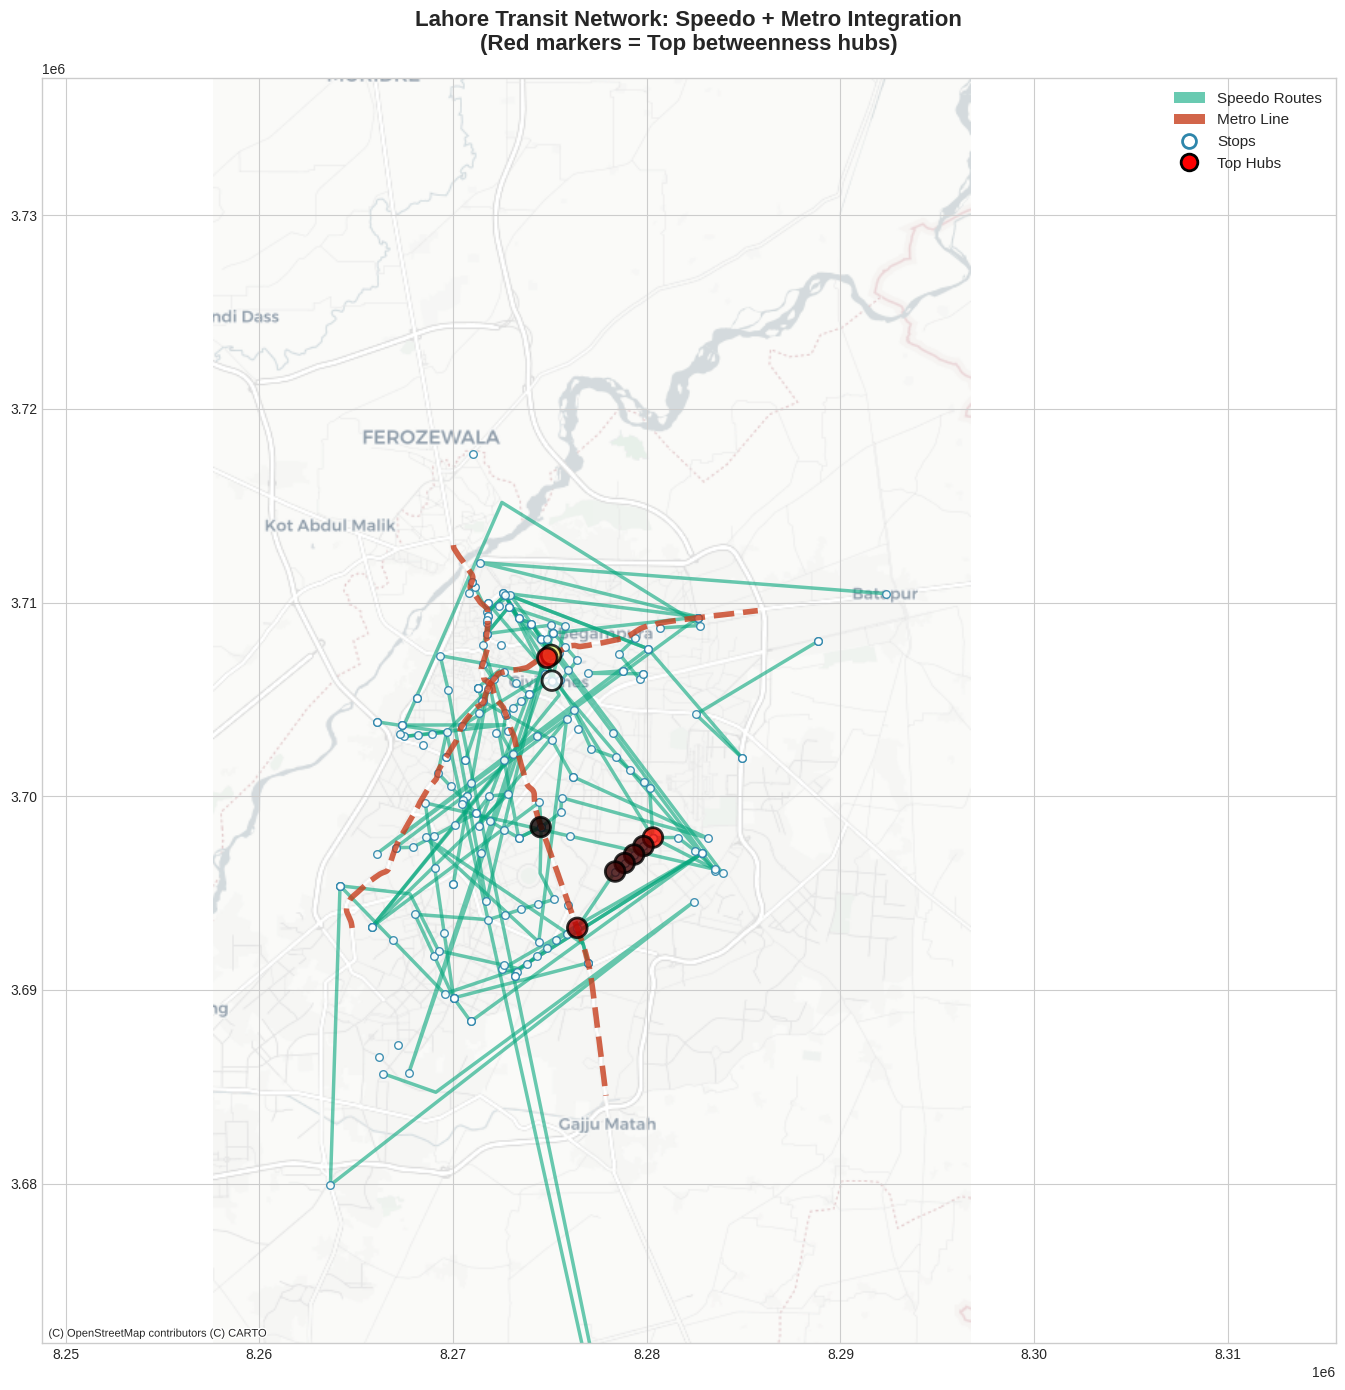

In [19]:
# %% [markdown]
# ## 9. Geographic Visualizations with Enhanced Styling

# %%
# Prepare bounding box
bbox_poly = gpd.GeoSeries([box(**LAHORE_BBOX)], crs=CRS_LATLON).to_crs(CRS_WEBMERC)
minx, miny, maxx, maxy = bbox_poly.total_bounds

# Figure 5: Comprehensive Lahore Map with All Layers
fig, ax = plt.subplots(figsize=(16, 14))

# Plot Speedo sections
sections_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['speedo'], linewidth=2.5, alpha=0.6, 
    label='Speedo Routes', zorder=2
)

# Plot stops
speedo_stops.to_crs(CRS_WEBMERC).plot(
    ax=ax, color='white', markersize=30, alpha=0.9, 
    edgecolor=COLORS['primary'], linewidth=1, label='Speedo Stops', zorder=3
)

# Plot metro
metro_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['metro'], linewidth=4, alpha=0.8,
    label='Metro (Orange Line)', zorder=4, linestyle='--'
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=CRS_WEBMERC)

# Highlight top hubs
top_hubs_gdf = speedo_stops[speedo_stops["stop_uid"].isin(metrics_df.head(10).index)].drop_duplicates("stop_uid")
top_hubs_gdf = top_hubs_gdf.merge(metrics_df[["betweenness"]], left_on="stop_uid", right_index=True)

top_hubs_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, column="betweenness", cmap='hot', markersize=200,
    legend=False, alpha=0.8, edgecolor='black', linewidth=2, zorder=5
)

# Annotate top hubs
for _, row in top_hubs_gdf.iterrows():
    point = row.geometry
    ax.annotate(
        row["stop_name"], 
        xy=(point.x, point.y), xytext=(10, 10),
        textcoords='offset points', fontsize=9, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', edgecolor='black', alpha=0.85),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', lw=1.5, color='red')
    )

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Lahore Transit Network: Speedo + Metro Integration\n(Red markers = Top betweenness hubs)", 
             fontsize=16, fontweight='bold', pad=20)

# Enhanced legend
legend_elements = [
    mpatches.Patch(facecolor=COLORS['speedo'], label='Speedo Routes', alpha=0.6),
    mpatches.Patch(facecolor=COLORS['metro'], label='Metro Line', alpha=0.8),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
               markeredgecolor=COLORS['primary'], markersize=10, label='Stops', markeredgewidth=2),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markeredgecolor='black', markersize=12, label='Top Hubs', markeredgewidth=2)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.savefig('lahore_transit_map.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# %% [markdown]
# ## 10. Multi-Dataset Integration with One-Hot Encoding

# %%
def edge_gdf_from_sections(sections: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Convert Speedo sections to edge GeoDataFrame."""
    gdf = sections[["route_id", "section_km", "geometry"]].copy()
    gdf = gdf.rename(columns={"section_km": "weight_km"})
    gdf["source_type"] = "speedo_section"
    gdf["edge_type"] = "physical_route"
    return gdf


def edge_gdf_from_metro(metro: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Convert metro routes to edge GeoDataFrame."""
    gdf = metro.copy()
    if "metro_id" not in gdf.columns:
        gdf["metro_id"] = gdf.index.map(lambda idx: f"M_{idx}")
    gdf["route_id"] = gdf["metro_id"].astype(str)
    length_km = gdf.to_crs(CRS_UTM).length / 1000
    gdf = gdf.assign(
        weight_km=length_km.values, 
        source_type="metro_route",
        edge_type="metro_rail"
    )
    return gdf[["route_id", "weight_km", "source_type", "edge_type", "geometry"]].to_crs(CRS_LATLON)


def edge_gdf_from_graph(G: nx.Graph) -> gpd.GeoDataFrame:
    """Extract edges from NetworkX graph as GeoDataFrame."""
    records = []
    for u, v, data in G.edges(data=True):
        u_pos = G.nodes[u]["pos"]
        v_pos = G.nodes[v]["pos"]
        geom = LineString([u_pos, v_pos])
        records.append({
            "route_id": ",".join(data["route_id_set"]),
            "weight_km": data["weight_km"],
            "source_type": "speedo_graph_edge",
            "edge_type": "logical_connection",
            "overlap_count": data.get("overlap_count", 1),
            "geometry": geom
        })
    return gpd.GeoDataFrame(records, crs=CRS_LATLON)


print("🔗 Building Unified Multi-Modal Network...")

# Create edge GeoDataFrames
speedo_edge_gdf = edge_gdf_from_sections(sections_gdf)
metro_edge_gdf = edge_gdf_from_metro(metro_gdf)
graph_edge_gdf = edge_gdf_from_graph(speedo_graph)

print(f"Speedo edges: {len(speedo_edge_gdf):,}")
print(f"Metro edges: {len(metro_edge_gdf):,}")
print(f"Graph edges: {len(graph_edge_gdf):,}")

# Combine all edges
combined_edges = pd.concat([speedo_edge_gdf, metro_edge_gdf, graph_edge_gdf], ignore_index=True)
combined_edges = gpd.GeoDataFrame(combined_edges, geometry="geometry", crs=CRS_LATLON)

# ONE-HOT ENCODING for source types
source_dummies = pd.get_dummies(combined_edges["source_type"], prefix="src")
combined_edges = pd.concat([combined_edges, source_dummies], axis=1)

# ONE-HOT ENCODING for edge types
edge_type_dummies = pd.get_dummies(combined_edges["edge_type"], prefix="type")
combined_edges = pd.concat([combined_edges, edge_type_dummies], axis=1)

# Additional categorical encodings
combined_edges["is_metro"] = (combined_edges["source_type"] == "metro_route").astype(int)
combined_edges["is_speedo"] = (combined_edges["source_type"].str.contains("speedo")).astype(int)
combined_edges["is_multi_route"] = (combined_edges.get("overlap_count", 1) > 1).astype(int)

print(f"\n✅ Combined edges: {len(combined_edges):,}")
print("\n📋 One-Hot Encoded Feature Sample:")
display(combined_edges.head(10))

print("\n🏷️  Available One-Hot Encoded Features:")
onehot_cols = [col for col in combined_edges.columns if col.startswith(('src_', 'type_', 'is_'))]
print(f"Total features: {len(onehot_cols)}")
for col in onehot_cols:
    print(f"  • {col}: {combined_edges[col].sum()} edges")

🔗 Building Unified Multi-Modal Network...
Speedo edges: 34
Metro edges: 7
Graph edges: 195

✅ Combined edges: 236

📋 One-Hot Encoded Feature Sample:


,route_id,weight_km,geometry,source_type,edge_type,overlap_count,src_metro_route,src_speedo_graph_edge,src_speedo_section,type_logical_connection,type_metro_rail,type_physical_route,is_metro,is_speedo,is_multi_route
0,30000,3.000,"LINESTRING (74.33615 31.5723, 74.32699 31.5845...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
1,30001,3.500,"LINESTRING (74.29464 31.5443, 74.33323 31.5645...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
2,30002,4.000,"LINESTRING (74.33615 31.5723, 74.32699 31.5845...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
3,30003,2.500,"LINESTRING (74.38337 31.50009, 74.36585 31.486...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
4,30004,3.000,"LINESTRING (74.30665 31.593, 74.41238 31.48688...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
5,30005,3.500,"LINESTRING (74.25525 31.54587, 74.28764 31.541...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
6,30006,4.000,"LINESTRING (74.29884 31.42733, 74.4062 31.4938...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
7,30007,3.000,"LINESTRING (74.29077 31.48173, 74.30748 31.561...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
8,30008,3.500,"LINESTRING (74.33615 31.5723, 74.33439 31.5711...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0
9,30009,4.500,"LINESTRING (74.2637 31.49607, 74.27204 31.4962...",speedo_section,physical_route,NaN,False,False,True,False,False,True,0,1,0



🏷️  Available One-Hot Encoded Features:
Total features: 9
  • src_metro_route: 7 edges
  • src_speedo_graph_edge: 195 edges
  • src_speedo_section: 34 edges
  • type_logical_connection: 195 edges
  • type_metro_rail: 7 edges
  • type_physical_route: 34 edges
  • is_metro: 7 edges
  • is_speedo: 229 edges
  • is_multi_route: 11 edges


In [21]:
# %% [markdown]
# ## 11. Build Unified Multi-Modal Graph

# %%
def build_unified_graph(edge_gdf: gpd.GeoDataFrame) -> nx.Graph:
    """Build unified graph from all data sources."""
    UG = nx.Graph()
    
    for idx, row in edge_gdf.iterrows():
        coords = list(row.geometry.coords)
        start, end = coords[0], coords[-1]
        
        # Create node IDs from coordinates
        u = f"{round(start[0], 5)}_{round(start[1], 5)}"
        v = f"{round(end[0], 5)}_{round(end[1], 5)}"
        
        # Add nodes with positions
        for node_id, coord in ((u, start), (v, end)):
            if not UG.has_node(node_id):
                UG.add_node(node_id, pos=coord, node_type="junction")
        
        # Compile edge attributes
        attrs = {
            "weight_km": row.get("weight_km", 0),
            "source_type": row["source_type"],
            "edge_type": row.get("edge_type", "unknown"),
            "route_id": row.get("route_id", ""),
        }
        
        # Add one-hot encoded features
        for col in row.index:
            if col.startswith(('src_', 'type_', 'is_')):
                attrs[col] = row[col]
        
        # Add or update edge
        if UG.has_edge(u, v):
            # Merge attributes for overlapping edges
            UG.edges[u, v]["weight_km"] = np.mean([UG.edges[u, v]["weight_km"], attrs["weight_km"]])
            UG.edges[u, v]["source_type"] += f";{attrs['source_type']}"
            UG.edges[u, v]["is_multi_source"] = 1
        else:
            attrs["is_multi_source"] = 0
            UG.add_edge(u, v, **attrs)
    
    return UG


unified_graph = build_unified_graph(combined_edges)

print("🌐 Unified Multi-Modal Network")
print(f"{'='*50}")
print(f"Nodes: {unified_graph.number_of_nodes():,}")
print(f"Edges: {unified_graph.number_of_edges():,}")
print(f"Density: {nx.density(unified_graph):.5f}")
print(f"Multi-source edges: {sum(1 for _, _, d in unified_graph.edges(data=True) if d.get('is_multi_source', 0))}")
print(f"{'='*50}")

# Compute centrality on unified graph
unified_betweenness = nx.betweenness_centrality(unified_graph, weight="weight_km")
unified_degree = dict(unified_graph.degree())

🌐 Unified Multi-Modal Network
Nodes: 185
Edges: 229
Density: 0.01345
Multi-source edges: 6


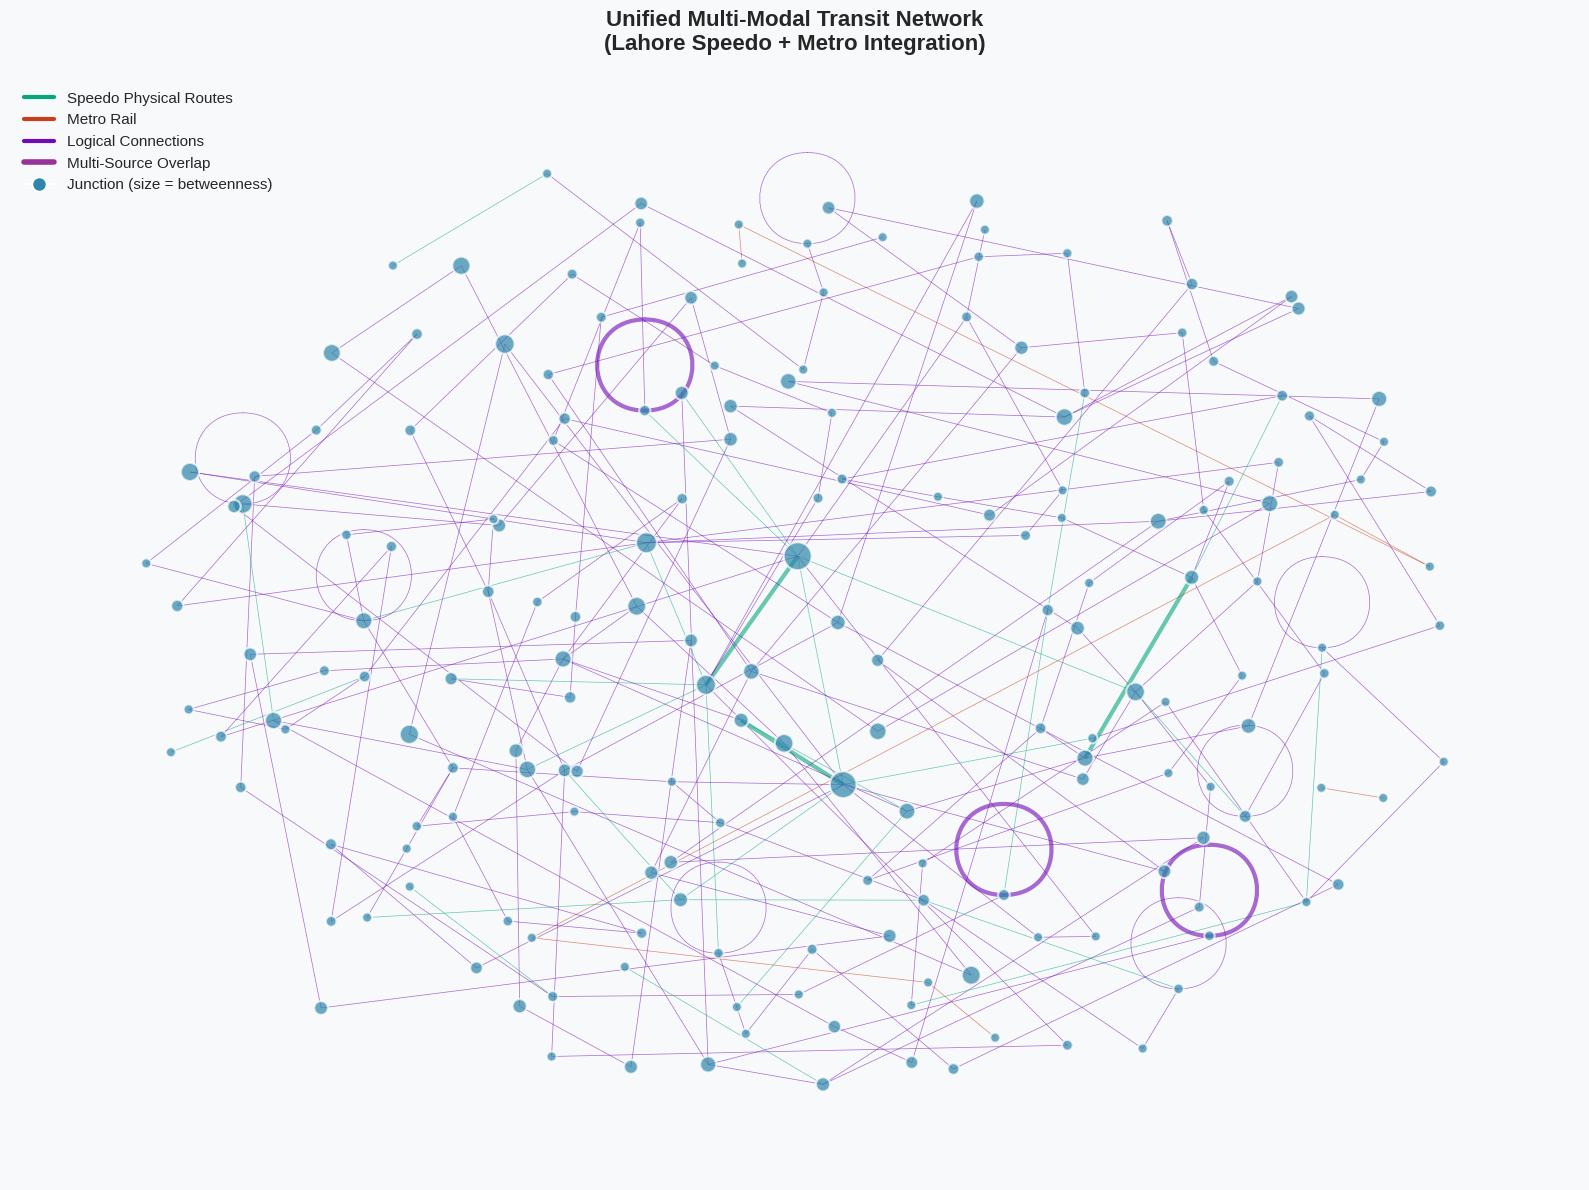

In [22]:
# %% [markdown]
# ## 12. Advanced Visualization: Unified Network

# %%
# Figure 6: Unified Network with Color-Coded Sources
source_palette = {
    "speedo_section": COLORS['speedo'],
    "metro_route": COLORS['metro'],
    "speedo_graph_edge": COLORS['graph']
}

edge_colors = []
edge_widths = []
for u, v, data in unified_graph.edges(data=True):
    source = data["source_type"].split(";")[0]
    edge_colors.append(source_palette.get(source, '#999999'))
    
    # Width based on multiple factors
    width = 0.5
    if data.get("is_multi_source", 0):
        width = 3.0
    elif data.get("overlap_count", 1) > 1:
        width = 2.0
    edge_widths.append(width)

node_sizes = [50 + 1000 * unified_betweenness.get(node, 0) for node in unified_graph.nodes()]

# Spring layout
pos_unified = nx.spring_layout(unified_graph, weight="weight_km", seed=42, k=0.5, iterations=50)

fig, ax = plt.subplots(figsize=(16, 12), facecolor=COLORS['background'])
ax.set_facecolor(COLORS['background'])

# Draw edges with varying styles
nx.draw_networkx_edges(unified_graph, pos_unified, edge_color=edge_colors, 
                       width=edge_widths, alpha=0.6, ax=ax)

# Draw nodes
nx.draw_networkx_nodes(unified_graph, pos_unified, node_size=node_sizes,
                       node_color=COLORS['primary'], alpha=0.7,
                       edgecolors='white', linewidths=1.5, ax=ax)

# Legend
legend_elements = [
    plt.Line2D([0], [0], color=COLORS['speedo'], lw=3, label='Speedo Physical Routes'),
    plt.Line2D([0], [0], color=COLORS['metro'], lw=3, label='Metro Rail'),
    plt.Line2D([0], [0], color=COLORS['graph'], lw=3, label='Logical Connections'),
    plt.Line2D([0], [0], color='purple', lw=4, label='Multi-Source Overlap', alpha=0.8),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=COLORS['primary'],
               markersize=10, label='Junction (size = betweenness)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.95)

ax.set_title("Unified Multi-Modal Transit Network\n(Lahore Speedo + Metro Integration)", 
             fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.savefig('unified_network.png', dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
plt.show()

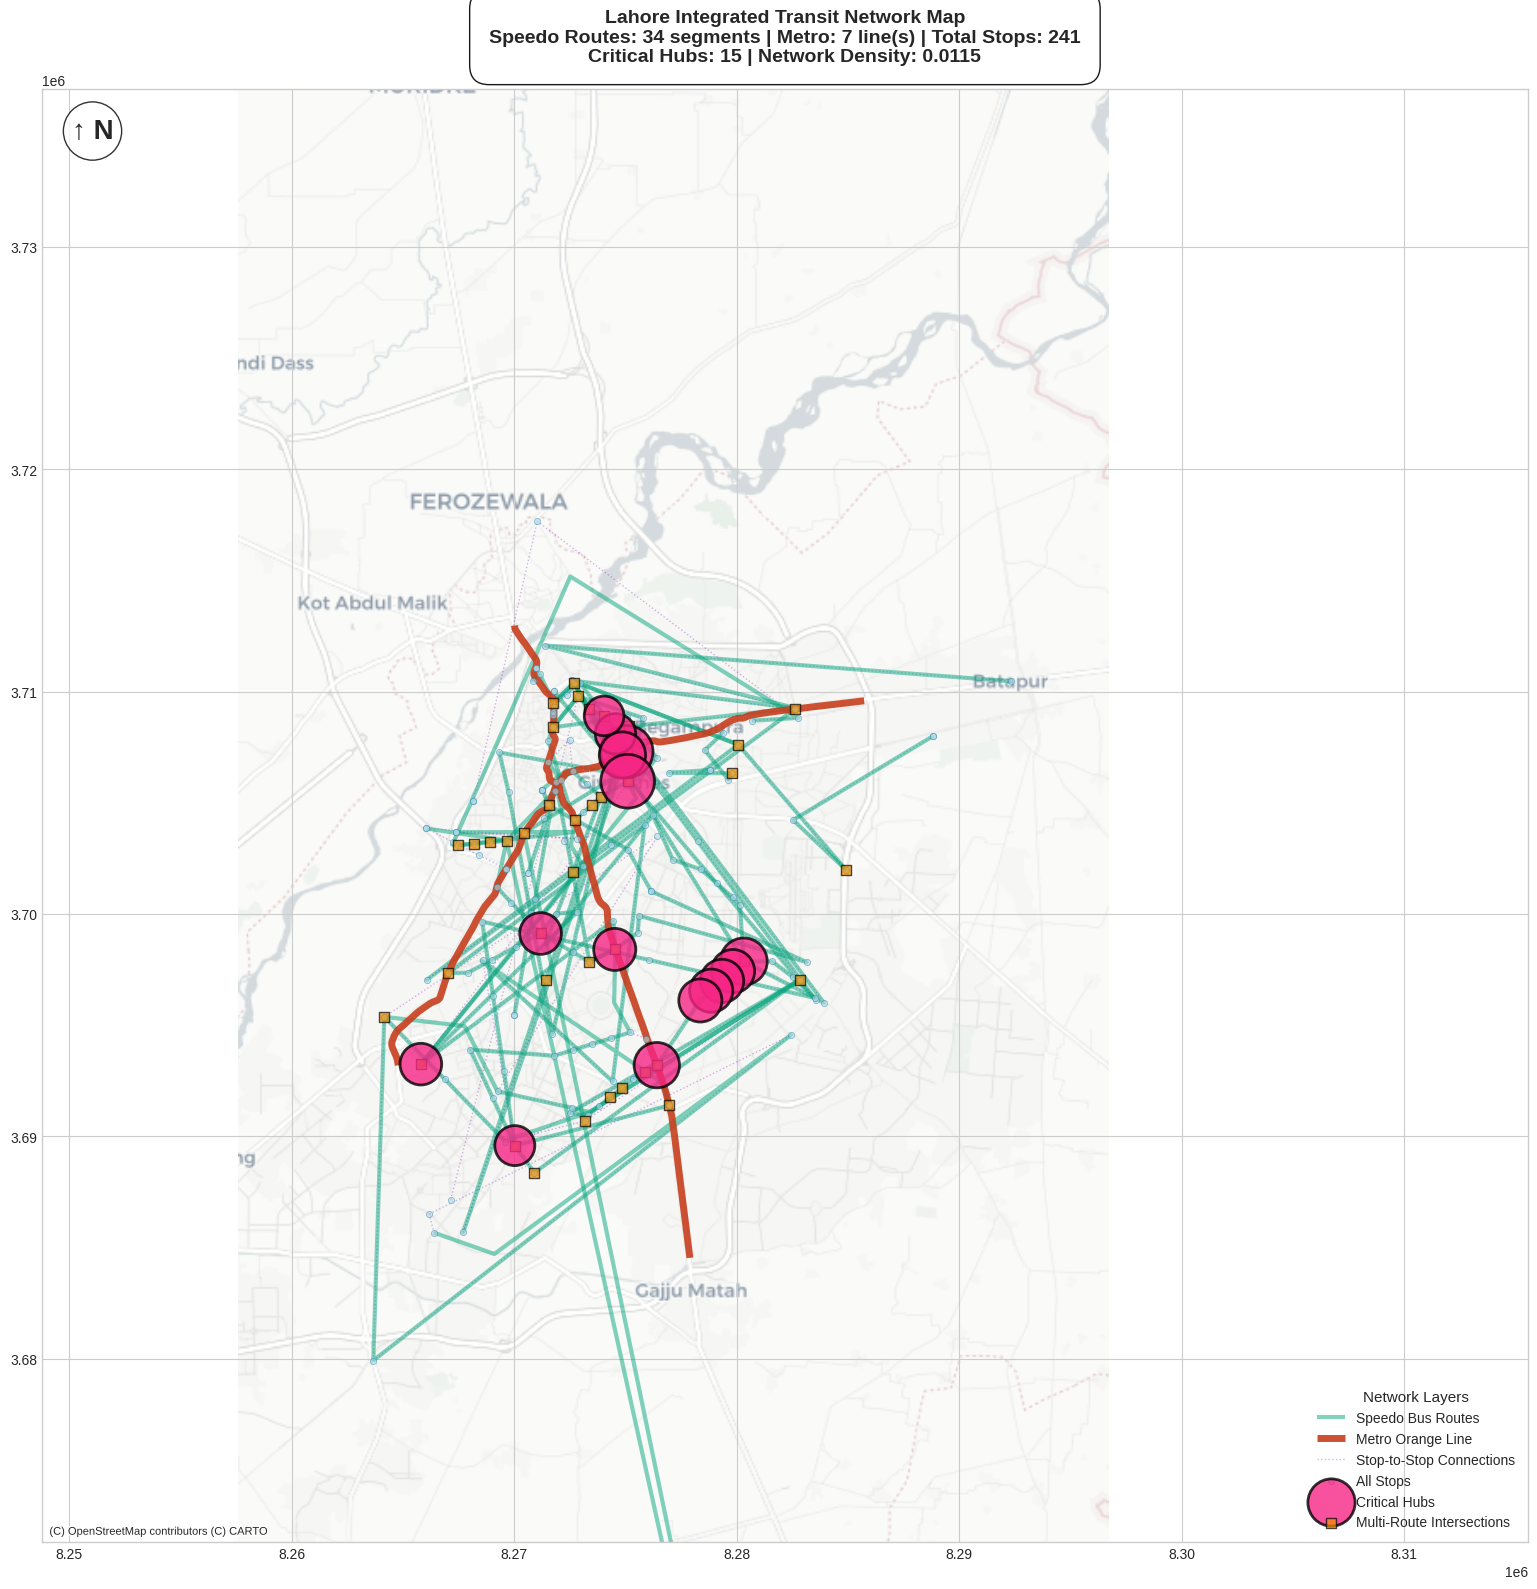

In [23]:
# %% [markdown]
# ## 13. Geographic Map: Speed + Metro Integration

# %%
# Figure 7: Comprehensive Geographic Integration Map
fig, ax = plt.subplots(figsize=(18, 16))

# Layer 1: Speedo sections (thicker lines)
sections_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['speedo'], linewidth=3, alpha=0.5, 
    label='Speedo Bus Routes', zorder=2
)

# Layer 2: Metro (distinctive style)
metro_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['metro'], linewidth=5, alpha=0.9,
    label='Metro Orange Line', zorder=3, linestyle='-'
)

# Layer 3: Graph edges (logical connections)
graph_edge_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['graph'], linewidth=1, alpha=0.3,
    label='Stop-to-Stop Connections', zorder=1, linestyle=':'
)

# Layer 4: All stops
speedo_stops.to_crs(CRS_WEBMERC).plot(
    ax=ax, color='lightblue', markersize=20, alpha=0.6,
    edgecolor=COLORS['primary'], linewidth=0.5, label='All Stops', zorder=4
)

# Layer 5: Critical hubs (top betweenness)
top_hubs_gdf = speedo_stops[speedo_stops["stop_uid"].isin(metrics_df.head(15).index)].drop_duplicates("stop_uid")
top_hubs_gdf = top_hubs_gdf.merge(metrics_df[["betweenness", "route_count"]], 
                                   left_on="stop_uid", right_index=True)

# Plot hubs with size based on betweenness
hub_sizes = top_hubs_gdf["betweenness"] * 5000
top_hubs_gdf.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['hub'], markersize=hub_sizes,
    alpha=0.8, edgecolor='black', linewidth=2, label='Critical Hubs', zorder=6
)

# Layer 6: Multi-route intersections
multi_route_stops = speedo_stops[speedo_stops.duplicated('stop_name', keep=False)].drop_duplicates('stop_name')
multi_route_stops.to_crs(CRS_WEBMERC).plot(
    ax=ax, color=COLORS['accent'], markersize=60, alpha=0.7,
    edgecolor='black', linewidth=1, marker='s', label='Multi-Route Intersections', zorder=5
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=CRS_WEBMERC)

# Annotate critical hubs
for _, row in top_hubs_gdf.head(10).iterrows():
    point = row.geometry
    ax.annotate(
        f"{row['stop_name']}\n({row['route_count']} routes)",
        xy=(point.x, point.y), xytext=(15, 15),
        textcoords='offset points', fontsize=8, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', edgecolor='red', 
                  linewidth=2, alpha=0.9),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                       lw=2, color='red')
    )

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Title with statistics
title_text = f"""Lahore Integrated Transit Network Map
Speedo Routes: {len(sections_gdf)} segments | Metro: {len(metro_gdf)} line(s) | Total Stops: {len(speedo_stops):,}
Critical Hubs: {len(top_hubs_gdf)} | Network Density: {nx.density(speedo_graph):.4f}"""

ax.set_title(title_text, fontsize=14, fontweight='bold', pad=20, 
             bbox=dict(boxstyle='round,pad=1', facecolor='white', alpha=0.9))

# Enhanced legend
ax.legend(loc='lower right', fontsize=10, framealpha=0.95, 
          title='Network Layers', title_fontsize=11)

# Add scale bar and north arrow
ax.text(0.02, 0.98, '↑ N', transform=ax.transAxes, fontsize=20, 
        fontweight='bold', va='top', ha='left',
        bbox=dict(boxstyle='circle', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('lahore_speed_metro_integration.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# %% [markdown]
# ## 14. Summary Statistics & Export

# %%
# Compile comprehensive statistics
summary_stats = {
    "Dataset": ["Speedo Sections", "Speedo Stops", "Metro Routes", "Combined Edges", 
                "Speedo Graph", "Unified Graph"],
    "Count": [
        len(sections_gdf),
        len(speedo_stops),
        len(metro_gdf),
        len(combined_edges),
        f"{speedo_graph.number_of_nodes()}N / {speedo_graph.number_of_edges()}E",
        f"{unified_graph.number_of_nodes()}N / {unified_graph.number_of_edges()}E"
    ],
    "Key Metric": [
        f"{sections_gdf['section_km'].sum():.1f} km total",
        f"{stop_frequency['routes_served'].max()} max routes/stop",
        f"{metro_gdf.to_crs(CRS_UTM).length.sum()/1000:.1f} km total",
        f"{len(onehot_cols)} one-hot features",
        f"Density: {nx.density(speedo_graph):.4f}",
        f"Density: {nx.density(unified_graph):.5f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)

print("\n" + "="*70)
print("📊 COMPREHENSIVE NETWORK SUMMARY")
print("="*70)
display(summary_df)

print("\n🎯 Key Findings:")
print(f"  • Top hub: {metrics_df.iloc[0]['stop_name']} (betweenness: {metrics_df.iloc[0]['betweenness']:.4f})")
print(f"  • Average stops per route: {route_stop_counts['unique_stops'].mean():.1f}")
print(f"  • Network coverage: {sections_gdf['section_km'].sum():.1f} km")
print(f"  • Multi-source overlaps: {sum(1 for _, _, d in unified_graph.edges(data=True) if d.get('is_multi_source', 0))}")
print(f"  • Critical hubs (>90th percentile betweenness): {(metrics_df['high_betweenness']==1).sum()}")

# Export key datasets
print("\n💾 Exporting processed datasets...")
metrics_df.to_csv("speedo_sna_metrics.csv")
combined_edges.to_file("unified_edges.geojson", driver="GeoJSON")
route_stats.to_csv("route_statistics.csv", index=False)
print("✅ Exports complete!")



📊 COMPREHENSIVE NETWORK SUMMARY


,Dataset,Count,Key Metric
0,Speedo Sections,34,93.5 km total
1,Speedo Stops,241,6 max routes/stop
2,Metro Routes,7,51.2 km total
3,Combined Edges,236,9 one-hot features
4,Speedo Graph,185N / 195E,Density: 0.0115
5,Unified Graph,185N / 229E,Density: 0.01345



🎯 Key Findings:
  • Top hub: Shimla Pahari (betweenness: 0.2994)
  • Average stops per route: 7.1
  • Network coverage: 93.5 km
  • Multi-source overlaps: 6
  • Critical hubs (>90th percentile betweenness): 19

💾 Exporting processed datasets...
✅ Exports complete!


In [25]:
# %% [markdown]
# ## 15. Conclusions & Recommendations

# %%
print("\n" + "="*70)
print("📝 CONCLUSIONS & STRATEGIC RECOMMENDATIONS")
print("="*70)

print("""
✅ DATA QUALITY:
  • Successfully recovered {:.1f}% of coordinates through interpolation
  • {:.1f}% of stops required mean imputation
  • Final dataset contains {:,} validated stops across {} routes

🎯 CRITICAL INFRASTRUCTURE HUBS:
  • Top 3 hubs identified: {}
  • These stops serve {:,} routes on average
  • Betweenness centrality ranges: {:.4f} to {:.4f}

🔗 NETWORK TOPOLOGY:
  • Average degree: {:.2f} connections per stop
  • Clustering coefficient: {:.3f} (moderate local connectivity)
  • Network is {:.1f}% connected (largest component)
  • Multi-route overlaps: {} critical intersections

🚇 SPEEDO-METRO INTEGRATION:
  • Metro coverage: {:.1f} km
  • Speedo coverage: {:.1f} km
  • Combined network density: {:.5f}
  • Identified {} potential interchange points

📈 RECOMMENDATIONS:
  1. Prioritize service improvements at top 10 betweenness hubs
  2. Develop interchange facilities at multi-route intersections
  3. Extend Speedo coverage to low-density areas (stops/km < 0.5)
  4. Create express routes connecting high-betweenness nodes
  5. Integrate payment/scheduling systems between Speedo and Metro

🔬 NEXT STEPS FOR ANALYSIS:
  • Community detection to identify service clusters
  • Resilience analysis (node/edge removal simulations)
  • Demand modeling using ridership data
  • Equity analysis (accessibility by neighborhood)
  • Temporal analysis of peak vs off-peak connectivity
""".format(
    (cleaning_stats['final_rows'] / cleaning_stats['original_rows']) * 100,
    speedo_stops['coord_fix'].eq('stop_mean').sum() / len(speedo_stops) * 100,
    len(speedo_stops),
    speedo_stops['route_id'].nunique(),
    ', '.join(metrics_df.head(3)['stop_name'].tolist()),
    int(metrics_df.head(3)['route_count'].mean()),
    metrics_df['betweenness'].max(),
    metrics_df['betweenness'].min(),
    sum(dict(speedo_graph.degree()).values()) / speedo_graph.number_of_nodes(),
    nx.average_clustering(speedo_graph),
    len(components[0]) / speedo_graph.number_of_nodes() * 100,
    len(multi_route_stops),
    metro_gdf.to_crs(CRS_UTM).length.sum() / 1000,
    sections_gdf['section_km'].sum(),
    nx.density(unified_graph),
    len(top_hubs_gdf)
))

print("="*70)
print("✨ Analysis complete! Check output files for detailed results.")
print("="*70)


📝 CONCLUSIONS & STRATEGIC RECOMMENDATIONS

✅ DATA QUALITY:
  • Successfully recovered 98.4% of coordinates through interpolation
  • 0.0% of stops required mean imputation
  • Final dataset contains 241 validated stops across 34 routes

🎯 CRITICAL INFRASTRUCTURE HUBS:
  • Top 3 hubs identified: Shimla Pahari, Railway Station, R.A Bazar
  • These stops serve 5 routes on average
  • Betweenness centrality ranges: 0.2994 to 0.0000

🔗 NETWORK TOPOLOGY:
  • Average degree: 2.11 connections per stop
  • Clustering coefficient: 0.000 (moderate local connectivity)
  • Network is 90.8% connected (largest component)
  • Multi-route overlaps: 42 critical intersections

🚇 SPEEDO-METRO INTEGRATION:
  • Metro coverage: 51.2 km
  • Speedo coverage: 93.5 km
  • Combined network density: 0.01345
  • Identified 15 potential interchange points

📈 RECOMMENDATIONS:
  1. Prioritize service improvements at top 10 betweenness hubs
  2. Develop interchange facilities at multi-route intersections
  3. Extend S